<a href="https://colab.research.google.com/github/sherryzhou0201/machine-learning/blob/master/Churn_Supervised_Learning_Project_Sherry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Churn Prediction

This project uses supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.


<li> data informaton
https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers


Churn--subscribed before, but then the customer left

## Contents

<ul>


<li>[Part 1: Data Exploration]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Pandas</li>
  <li style="margin-left:2em; padding-bottom: 0;">pyspark</li>
</ol>
<li>[Part 2: Feature Preprocessing]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Pandas</li>
  <li style="margin-left:2em; padding-bottom: 0;">pyspark</li>
</ol>
<li>[Part 3: Model Training and Results Evaluation]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Pandas</li>
  <li style="margin-left:2em; padding-bottom: 0;">pyspark</li>
</ol>
<li>[Part 4: Feature Selection]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Pandas</li>
  <li style="margin-left:2em; padding-bottom: 0;">pyspark</li>
</ol>
</ul>

# Part 0: Setup Google Drive Environment

<li> Google drive was set up following the steps :

https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92



In [1]:
# method 1 install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link = 'https://drive.google.com/open?id=1R1Zt68U6aPw9OW9qWob2U41EX1YukG14'
fluff, id = link.split('=')
print(fluff)
print(id)
file=drive.CreateFile({'id':id})
file.GetContentFile('bank_churn.csv')

https://drive.google.com/open?id
1R1Zt68U6aPw9OW9qWob2U41EX1YukG14


# Part 1: Data Exploration


### Part 1.1: Understand the Raw Dataset

This is a data set with only 1M records, it does not take long to only use the pandas package. However, for practice purpose, I will also use pyspark

In [3]:
import pandas as pd

churn_df = pd.read_csv('bank_churn.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# check data info
churn_df.info() # it is like the str function in R

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# check the # of unique values for each column
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [ ]:
# get target variable
# this is just an example, notice the name showed in the upper cell
y=churn_df['Exited'] # column name
print(y)
# check the proporiton of y=1
print(y.sum()/y.shape*100) # 20.37%

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64
[20.37]


### Part 1.2:  Understand the features

In [ ]:
churn_df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# understand the numerical features
# discrete/continuous
# -- I personally does not 100% agree with the defination of discrete and continuous here 
# but I guess here we think as long as there are not infinite number of possiblities , then it is a discrete variable
# if this is the case, then the discrete variables are : CredisScore, Age, Genure, Number of Products
# continuous: "Balance" ," EsitiamtesSalary"
churn_df[['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']].describe()  # similar to the "summary" function in R
# If i understand correctly, here we use  [[]] rather than [] only is becasue dataframe[one element only], if we have multiple columns
# we put them into a list, so there is still only one element in the [].


,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


In [ ]:
churn_df.shape # number of row and number of columns of the dataset

(10000, 14)

In [ ]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 10000
Num of columns: 14


In [ ]:
# check the misisng values
churn_df.isnull() # this gives you the data set with T/F only
churn_df.isnull().sum() # this sums up the T for each column

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# check the feature distribution
# do boxplot, distplot, countplot
import matplotlib.pyplot as plt
import seaborn as sns 
# I use R a lot in .rmd file, I think now the databrick does not support ggplot when writing python any more. Not sure about the google colab
# But, note to myself, just try to switch all the stuff you did using ggplot2 before to seaborn/matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0.98, 'Boxplot for numberical features')

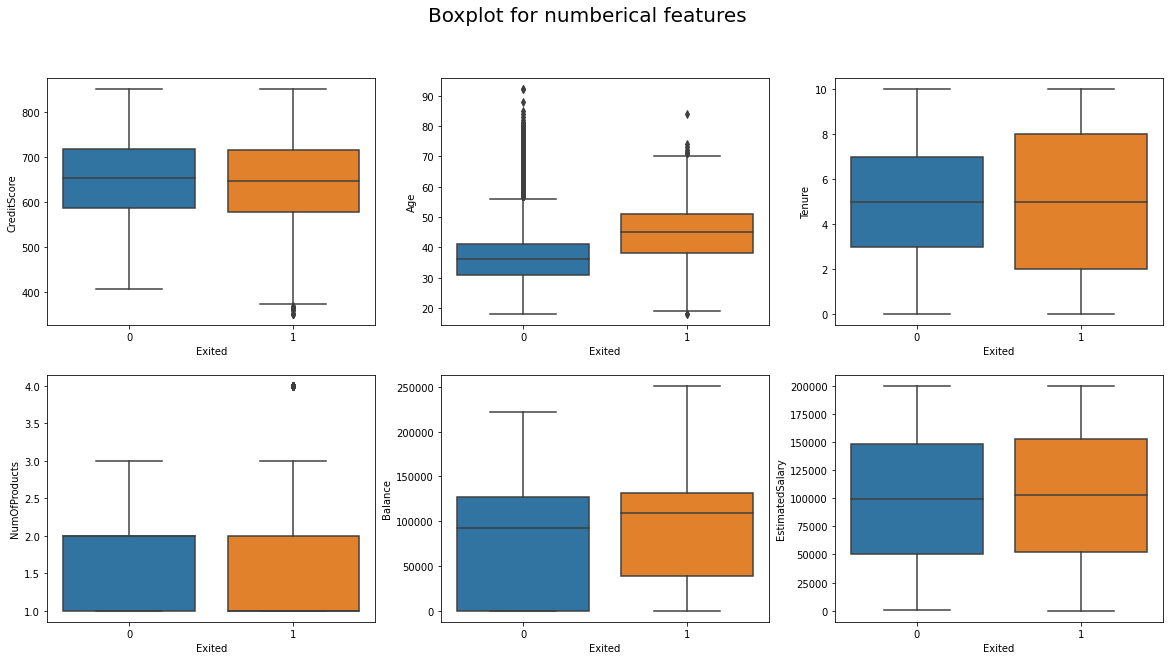

In [ ]:
# boxplot for numerical features
fig,axss=plt.subplots(2,3,figsize=[20,10])
sns.boxplot(x='Exited',y='CreditScore',data=churn_df,ax=axss[0][0])
sns.boxplot(x='Exited',y='Age',data=churn_df,ax=axss[0][1])
sns.boxplot(x='Exited',y='Tenure',data=churn_df,ax=axss[0][2])
sns.boxplot(x='Exited',y='NumOfProducts',data=churn_df,ax=axss[1][0])
sns.boxplot(x='Exited',y='Balance',data=churn_df,ax=axss[1][1])
sns.boxplot(x='Exited',y='EstimatedSalary',data=churn_df,ax=axss[1][2])

fig.suptitle("Boxplot for numberical features",fontsize=20)

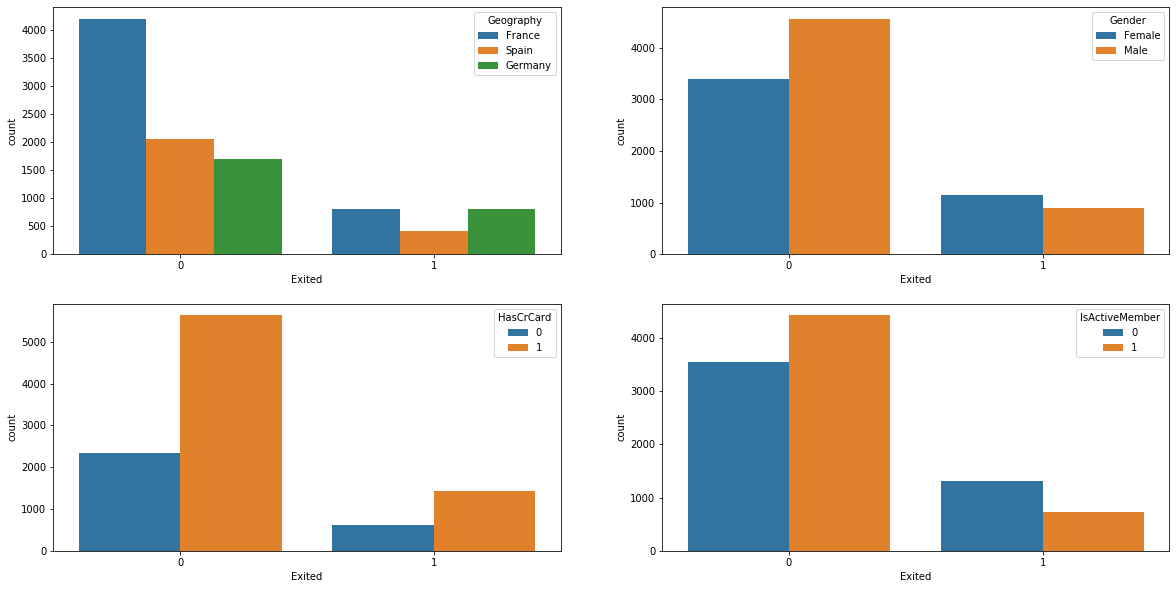

In [ ]:
# undersatnd categorical features
figure,axss=plt.subplots(2,2,figsize=[20,10])
# hue -- levels to plot the levels in -- for cateogrical variables. similar to color= varaible in R
sns.countplot(x="Exited",hue='Geography',data=churn_df,ax=axss[0][0])
sns.countplot(x='Exited',hue='Gender',data=churn_df,ax=axss[0][1])
sns.countplot(x='Exited',hue='HasCrCard',data=churn_df,ax=axss[1][0])
sns.countplot(x='Exited',hue='IsActiveMember',data=churn_df,ax=axss[1][1])

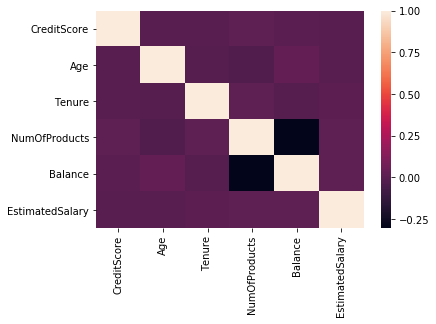

In [ ]:
# correlations between all the features
corr = churn_df[['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [ ]:
# check the actual values of correlations
corr.round(2)

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
CreditScore,1.00,-0.00,0.00,0.01,0.01,-0.00
Age,-0.00,1.00,-0.01,-0.03,0.03,-0.01
Tenure,0.00,-0.01,1.00,0.01,-0.01,0.01
NumOfProducts,0.01,-0.03,0.01,1.00,-0.30,0.01
Balance,0.01,0.03,-0.01,-0.30,1.00,0.01
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,1.00


# Part 2: Feature Preprocessing

<li> feature encoding
<li> feature scaling


for more inforamation of handling categorical features, refer to this website:
https://github.com/scikit-learn-contrib/categorical-encoding

package for encoding:
https://contrib.scikit-learn.org/categorical-encoding/#category-encoders


In [ ]:
# ordinal encoding -- the defination is confusing actaully. From the statistic perspective, I don't think we should call this type ordianl encoding
# I will prefer to name it nominal encoding ,but anyway this type encoding means change the nominal data to numbers.
# differetn integer does not have to be a rating scale
churn_df['Gender']=churn_df['Gender']=='Female'
churn_df['Gender'] # change to True and False now .

0        True
1        True
2        True
3        True
4        True
        ...  
9995    False
9996    False
9997     True
9998    False
9999     True
Name: Gender, Length: 10000, dtype: bool

In [ ]:
# one hot encoding
# drop_first=True -- remove the raw column
churn_df=pd.get_dummies(churn_df,columns=["Geography"],drop_first=True)


In [ ]:
churn_df.info

<bound method DataFrame.info of       RowNumber  CustomerId  ... Geography_Germany  Geography_Spain
0             1    15634602  ...                 0                0
1             2    15647311  ...                 0                1
2             3    15619304  ...                 0                0
3             4    15701354  ...                 0                0
4             5    15737888  ...                 0                1
...         ...         ...  ...               ...              ...
9995       9996    15606229  ...                 0                0
9996       9997    15569892  ...                 0                0
9997       9998    15584532  ...                 0                0
9998       9999    15682355  ...                 1                0
9999      10000    15628319  ...                 0                0

[10000 rows x 15 columns]>

In [ ]:
# drop useless features
to_drop=['RowNumber','CustomerId','Surname','Exited']
X=churn_df.drop(to_drop,axis=1)

In [ ]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,619,True,42,2,0.00,1,1,1,101348.88,0,0
1,608,True,41,1,83807.86,1,0,1,112542.58,0,1
2,502,True,42,8,159660.80,3,1,0,113931.57,0,0
3,699,True,39,1,0.00,2,0,0,93826.63,0,0
4,850,True,43,2,125510.82,1,1,1,79084.10,0,1


# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [ ]:
# Splite data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,stratify=y)
# stratify will keep the pattern of y, e.g. overall, you have 10% 1 and 90% 0, then within the 20% test data,
# you will also have 10% 1 and 90% 0, that provides you the same patter for you training data and test data  

print('training data has %d observation with %d features'% X_train.shape) # shape return # of rows, # of columns
print('test data has %d observation with %d features'% X_test.shape)

training data has 8000 observation with 11 features
test data has 2000 observation with 11 features


In [ ]:
# Scale the data, using standardization
# standardization (x-mean)/std --- common
# normalization (x-x_min)/(x_max-x_min)

# advantage using standardization and normalization
# 1. speed up gradient descent
# 2. same scale
# 3. algorithm requirements


# for example, use training data to train the standardscaler to get mean and std 
# apply mean and std to both training and testing data.
# fit_transform does the training and applying, transform only does applying.
# Because we can't use any info from test, and we need to do the same modification
# to testing data as well as training data

# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# https://scikit-learn.org/stable/modules/preprocessing.html


# min-max example: (x-x_min)/(x_max-x_min)
# [1,2,3,4,5,6] -> fit(min:1, max:6) (scalar.min = 1, scalar.max = 6) -> transform [(1-1)/(6-1),(2-1)/(6-1)..]
# scalar.fit(train) -> min:1, max:100
# scalar.transform(apply to x) -> apply min:1, max:100 to X_train
# scalar.transform -> apply min:1, max:100 to X_test

# scalar.fit -> mean:1, std:100
# scalar.transform -> apply mean:1, std:100 to X_train
# scalar.transform -> apply mean:1, std:100 to X_test

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# training data--we did the fit transform, based on its mean and sd
scaler.fit(X_train) # get the mean/sd from X_train
X_train = scaler.fit_transform(X_train)
# test data- we only do the same transfrom as we did for the training data
# we do not want to add mean/sd info from the test data set 
# so here we only did the transform based on the X_train
# so here scaler.trasnform(X_test) --> (is x-train_mean)/train_std
X_test = scaler.transform(X_test)

### Part 3.2: Model Training and Selection

In [ ]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [ ]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Prediction of test data
classifier_logistic.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.802

In [ ]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

[0.8125   0.8125   0.814375 0.816875 0.808125]
Model accuracy of Logistic Regression is: 0.813
[0.825    0.82125  0.824375 0.831875 0.823125]
Model accuracy of KNN is: 0.825
[0.85625  0.859375 0.86625  0.863125 0.85875 ]
Model accuracy of Random Forest is: 0.861


<li> prediction with SVM model

In [ ]:

# SVC -- SVE Classifier
# soft voting ensemble (SVE) technique which assigns higher weights to the classifiers with respect to their prediction accuracy
from sklearn.svm import SVC 
model_name=['Soft Voting Ensemble']
classifier_SVC = SVC()

cv_score = model_selection.cross_val_score(classifier_SVC, X_train, y_train, cv=5)
print('Model accuracy of SVM is: %.3f'%(cv_score.mean()))


Model accuracy of SVM is: 0.859


### (Optional) Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [ ]:
# hyperparameters in RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
# C -- bigger, penalize -- smaller


parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}

Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.813
Best parameters set:
	C: 1
	penalty: 'l1'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [ ]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [ ]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.832
Best parameters set:
	n_neighbors: 10


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.865
Best parameters set:
	n_estimators: 80


In [ ]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 

Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In this situation, recall is more important than precision

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.855
precision is: 0.728
recall is: 0.455


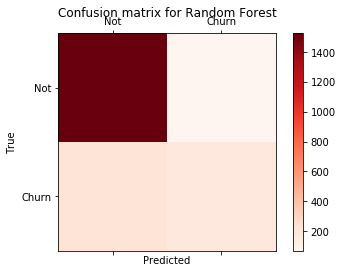

Logistic Regression
Accuracy is: 0.802
precision is: 0.538
recall is: 0.192


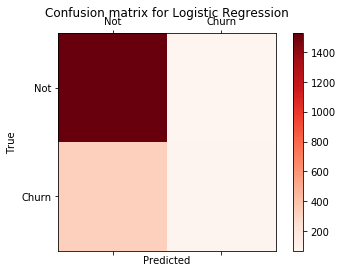

In [ ]:
# the sequence: true value first， and the prediction
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [ ]:
best_RF_model.predict_proba(X_test) # predict class probability

array([[0.9   , 0.1   ],
       [0.9625, 0.0375],
       [0.7625, 0.2375],
       ...,
       [0.8875, 0.1125],
       [0.1   , 0.9   ],
       [0.7375, 0.2625]])

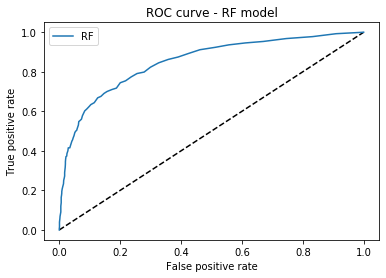

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score -- area under curve
metrics.auc(fpr_rf,tpr_rf)

0.8506326048698931

#### Part 3.4.1: ROC of LR Model

In [ ]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

In [ ]:
best_LR_model.predict_proba(X_test)

array([[0.89833896, 0.10166104],
       [0.90111655, 0.09888345],
       [0.92493896, 0.07506104],
       ...,
       [0.95617106, 0.04382894],
       [0.35412624, 0.64587376],
       [0.70765875, 0.29234125]])

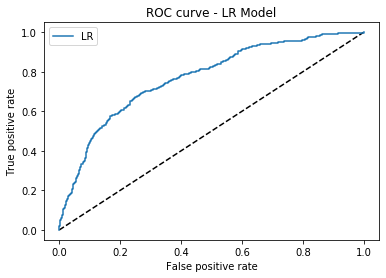

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7698006172582443

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The correlated features that we are interested in:

In [ ]:
X_with_corr=X.copy()
X_with_corr['SalaryInRMB']=X['EstimatedSalary']*6.94

In [ ]:
# add L1 regularization to logistic regression
# check the coef for feature selection
# L1-LASSO L2-RIDGE
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1,solver="liblinear") # if default solver lbfgs only suppports L2 or none  
# see document :https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
LRmodel_l1.fit(X_l1, y)

indices=np.argsort(abs(LRmodel_l1.coef_[0]))[::-1] # sort by value from largest to smallest, the return values are the index 

print ("Logistic Regression (L1) Coefficients")
for ind in indices:
    print ("{0}: {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]],4)))

Logistic Regression (L1) Coefficients
Geography_Germany: 0.3251
Tenure: -0.0384
HasCrCard: -0.0131
IsActiveMember: -0.524
Balance: 0.159
Age: 0.7495
CreditScore: -0.0568
Gender: 0.254
EstimatedSalary: 0.0176
NumOfProducts: -0.0528
Geography_Spain: 0.0027
SalaryInRMB: 0.0025


In [ ]:
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1,solver='liblinear')
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

array([-0.06365791,  0.25913309,  0.75097478, -0.04519968,  0.16236888,
       -0.05849101, -0.01993048, -0.52713546,  0.01367295,  0.33134327,
        0.01389489,  0.01367295])

In [ ]:
# add L2 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1,solver='liblinear')
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in indices:
    print ("{0}:{1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]],4)))
  

Logistic Regression (L2) Coefficients
Geography_Germany:0.3313
Tenure:-0.0452
Geography_Spain:0.0139
IsActiveMember:-0.5271
Balance:0.1624
Age:0.751
CreditScore:-0.0637
Gender:0.2591
NumOfProducts:-0.0585
EstimatedSalary:0.0137
HasCrCard:-0.0199
SalaryInRMB:0.0137


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

indices=np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
    print ("{0}:{1}".format(X.columns[indices[ind]],round(importances[indices[ind]],4)))

Feature importance ranking by Random Forest Model:
Age:0.2409
EstimatedSalary:0.1479
Balance:0.143
CreditScore:0.1407
NumOfProducts:0.1301
Tenure:0.0814
IsActiveMember:0.0399
Geography_Germany:0.0263
HasCrCard:0.0185
Gender:0.0181
Geography_Spain:0.0131


The previous results show that age is the main feature that affects customers' churn. 

If we go back to the boxplot, we noticed that the people averaged over 45 years old has more tendancy to churn comparing to the younger group. 